In [92]:
pip install scikit-plot

In [93]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sqlite3 as sql
import seaborn as sns
import re
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
import time
# import umap
#pip install PrettyTable

#pip install scikit-plot
#pip install gensim
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import metrics
import scikitplot as skplt
import gensim
from datetime import timedelta
import os
from scipy import sparse
from prettytable import PrettyTable
from itertools import product
from mpl_toolkits.mplot3d import Axes3D

import keras
#from keras.datasets import imdb
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
# fix random seed for reproducibility
np.random.seed(7)
# import plotly_express as px
# from plotly.offline import plot

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [94]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [95]:
!ls

 database5.sqlite
 database.sqlite
 final.sqlite
'G:\database_assignment\Logistic_regression\database5.sqlite'
 gdrive
 sample_data


In [96]:
!pwd

/content


In [97]:
# using SQLite Table to read data.
con = sqlite3.connect('/content/gdrive/MyDrive/database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(" SELECT * FROM Reviews WHERE Score != 3 ", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (525814, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,good,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [98]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [99]:
print("size of our data is", filtered_data.shape)
print("")
filtered_data.info()

size of our data is (525814, 10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 525814 entries, 0 to 525813
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Id                      525814 non-null  int64 
 1   ProductId               525814 non-null  object
 2   UserId                  525814 non-null  object
 3   ProfileName             525814 non-null  object
 4   HelpfulnessNumerator    525814 non-null  int64 
 5   HelpfulnessDenominator  525814 non-null  int64 
 6   Score                   525814 non-null  int64 
 7   Time                    525814 non-null  int64 
 8   Summary                 525814 non-null  object
 9   Text                    525814 non-null  object
dtypes: int64(5), object(5)
memory usage: 40.1+ MB


In [100]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


In [101]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [102]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(364173, 10)

In [103]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

69.25890143662969

In [104]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [105]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [106]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(364171, 10)


1    307061
0     57110
Name: Score, dtype: int64

In [107]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college
I was really looking forward to these pods based on the reviews.  Starbucks is good, but I prefer bolder taste.... imagine my surprise when I ordered 2 boxes - both were expired! One expired back in 2005 for gosh sakes.  I admit that Amazon agreed to credit me for cost plus part of shipping, but geez, 2 years expired!!!  I'm hoping to find local San Diego area shoppe that carries pods so that I can try something different than starbucks.
Great ingredients although, chicken should have been 1st rather than chicken broth, the only thing I do not think belongs in it is Canola oil. Canola or rapeseed is not someting a do

In [108]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college


In [109]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college
I was really looking forward to these pods based on the reviews.  Starbucks is good, but I prefer bolder taste.... imagine my surprise when I ordered 2 boxes - both were expired! One expired back in 2005 for gosh sakes.  I admit that Amazon agreed to credit me for cost plus part of shipping, but geez, 2 years expired!!!  I'm hoping to find local San Diego area shoppe that carries pods so that I can try something different than starbucks.
Great ingredients although, chicken should have been 1st rather than chicken broth, the only thing I do not think belongs in it is Canola oil. Canola or rapeseed is not someting a do

In [110]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [111]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

Great ingredients although, chicken should have been 1st rather than chicken broth, the only thing I do not think belongs in it is Canola oil. Canola or rapeseed is not someting a dog would ever find in nature and if it did find rapeseed in nature and eat it, it would poison them. Today is Food industries have convinced the masses that Canola oil is a safe and even better oil than olive or virgin coconut, facts though say otherwise. Until the late 70 is it was poisonous until they figured out a way to fix that. I still like it but it could be better.


In [112]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college


In [113]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [114]:
# Combining all the above stundents 
if not os.path.isfile('final.sqlite'):
    
    from tqdm import tqdm
    final_string=[]
    # tqdm is for printing the status bar
    for sentance in tqdm(final['Text'].values):
        sentance = re.sub(r"http\S+", "", sentance)
        sentance = BeautifulSoup(sentance, 'lxml').get_text()
        sentance = decontracted(sentance)
        sentance = re.sub("\S*\d\S*", "", sentance).strip()
        sentance = re.sub('[^A-Za-z]+', ' ', sentance)
        # https://gist.github.com/sebleier/554280
        sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
        final_string.append(sentance.strip())
        
         #############---- storing the data into .sqlite file ------########################
    final['CleanedText']=final_string #adding a column of CleanedText which displays the data after pre-processing of the review 
    final['CleanedText']=final['CleanedText'].str.decode("utf-8")
        # store final table into an SQlLite table for future.
    conn = sqlite3.connect('final.sqlite')
    c=conn.cursor()
    conn.text_factory = str
    final05.to_sql('Reviews', conn,  schema=None, if_exists='replace',  index=True, index_label=None, chunksize=None, dtype=None)
    conn.close()
   

In [115]:
if os.path.isfile('final.sqlite'):
    conn = sqlite3.connect('/content/gdrive/MyDrive/final5.sqlite')
    final1 = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, conn)
    conn.close()
else:
    print("Please the above cell")

In [116]:
final1.head(3)
final1['CleanedText'].head(5)

0    witti littl book make son laugh loud recit car...
1    grew read sendak book watch realli rosi movi i...
2    fun way children learn month year learn poem t...
3    great littl book read nice rhythm well good re...
4    book poetri month year goe month cute littl po...
Name: CleanedText, dtype: object

In [117]:
sorted_sample = final1.sort_values('Time', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')    
sample_60000 = sorted_sample.iloc[0:100000]
final.shape
y = sample_60000['Score']


In [118]:
sample_60000.shape

(100000, 12)

In [119]:
sample_60000["length"] = sample_60000['Text'].apply(len)

In [120]:
sample_60000.shape

(100000, 13)

In [121]:
y.shape

(100000,)

In [122]:
sample_60000.head(3)

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText,length
0,138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witti littl book make son laugh loud recit car...,375
30,138683,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,positive,940809600,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...,rememb see show air televis year ago child sis...,407
424,417839,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,positive,944092800,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...,beetlejuic well written movi everyth excel act...,166


In [123]:
sample_60000['Score'].value_counts()

positive    87729
negative    12271
Name: Score, dtype: int64

In [124]:
train_df = sample_60000[:60000]
cv_df = sample_60000[60000:80000]
test_df = sample_60000[80000:100000]

In [125]:
train_df.shape

(60000, 13)

In [126]:
def word_freq_seq(train_reviews,validation_reviews, test_reviews):
    count_vect = CountVectorizer()
    count_vect.fit(train_reviews)
    count_vect_xtrain = count_vect.transform(train_reviews)
    word_frequencies = count_vect_xtrain.sum(axis=0)
    word_count_list = [(word, count) for word, count in zip(count_vect.get_feature_names(), np.array(word_frequencies)[0])]
    word_freq_df = pd.DataFrame(sorted(word_count_list, key=lambda x: x[1], reverse=True), columns = ['word', 'frequency'])
    word_freq_df['freq_index'] = np.array(word_freq_df.index)+1
    print(word_freq_df.head())
    ax = sns.barplot(data=word_freq_df[:20], y='word', x='frequency')
    ax.set_title("top 20 words")
    plt.tight_layout()
    plt.show()
    
    # creating the vocabulary dict which contains the top 5k words and there frequency indexing.
    train_vocab_dict = {}
    for row in word_freq_df[:5000].iterrows():
        train_vocab_dict[row[1]['word']] = [row[1]['frequency'], row[1]['freq_index']]
    
    
    train_reviews_list = []
    cv_reviews_list = []
    test_reviews_list = []
    
    
    
    def gen_seq_from_dict(reviews_list, vocab_index_dict):
        final_reviews_index_list = []
        for review in reviews_list:
            review_list = []
            for word in review.lower().split():
                try:
                    review_list.append(vocab_index_dict[word][1])
                except:
                    pass
            final_reviews_index_list.append(np.array(review_list))
        return final_reviews_index_list
    
        
    train_encoded_reviews = gen_seq_from_dict(train_reviews, train_vocab_dict)
    valid_encoded_reviews = gen_seq_from_dict(validation_reviews, train_vocab_dict)
    test_encoded_reviews = gen_seq_from_dict(test_reviews, train_vocab_dict)
    
    return train_encoded_reviews, valid_encoded_reviews, test_encoded_reviews

     word  frequency  freq_index
0    like      25563           1
1    tast      25454           2
2     tea      20606           3
3    good      20315           4
4  flavor      20163           5


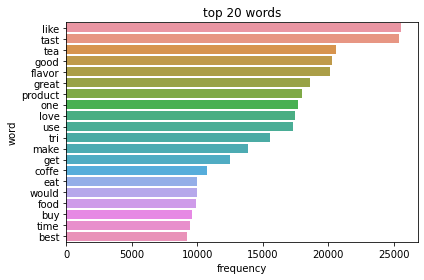

In [127]:
train_encoded_reviews, valid_encoded_reviews, test_encoded_reviews = word_freq_seq(train_df.CleanedText, cv_df.CleanedText, test_df.CleanedText)

In [128]:
# truncate and/or pad input sequences
max_review_length = 400
X_train = sequence.pad_sequences(train_encoded_reviews, maxlen=max_review_length)
X_cv = sequence.pad_sequences(valid_encoded_reviews, maxlen=max_review_length)
X_test = sequence.pad_sequences(test_encoded_reviews, maxlen=max_review_length)

print(X_train.shape)
print(X_train[1])

(60000, 400)
[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    

In [129]:
def text_to_num(series):
    num_array = []
    for x in series:
        if x == 'Positive':
            num_array.append(1)
        else:
            num_array.append(0)
    return np.array(num_array)

In [130]:
y_train = text_to_num(train_df.Score)
y_cv = text_to_num(cv_df.Score)
y_test = text_to_num(test_df.Score)

In [131]:
embedding_vecor_length = 32
model = Sequential()
model.add(Embedding(5000+1, embedding_vecor_length, input_length=max_review_length))
model.add(LSTM(100))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 400, 32)           160032    
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               53200     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 213,333
Trainable params: 213,333
Non-trainable params: 0
_________________________________________________________________
None


In [132]:
model.fit(X_train, y_train, epochs=10, batch_size=64)
# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Epoch 1/10
938/938 [==============================] - 417s 442ms/step - loss: 0.0068 - accuracy: 0.9997
Epoch 2/10
938/938 [==============================] - 416s 444ms/step - loss: 4.9185e-06 - accuracy: 1.0000
Epoch 3/10
938/938 [==============================] - 414s 441ms/step - loss: 2.0760e-06 - accuracy: 1.0000
Epoch 4/10
938/938 [==============================] - 414s 441ms/step - loss: 1.0920e-06 - accuracy: 1.0000
Epoch 5/10
938/938 [==============================] - 414s 441ms/step - loss: 6.2900e-07 - accuracy: 1.0000
Epoch 6/10
938/938 [==============================] - 414s 442ms/step - loss: 3.7894e-07 - accuracy: 1.0000
Epoch 7/10
938/938 [==============================] - 415s 443ms/step - loss: 2.3381e-07 - accuracy: 1.0000
Epoch 8/10
938/938 [==============================] - 414s 442ms/step - loss: 1.4618e-07 - accuracy: 1.0000
Epoch 9/10
938/938 [==============================] - 414s 442ms/step - loss: 9.2087e-08 - accuracy: 1.0000
Epoch 10/10
938/938 [===========

In [138]:
from keras.layers import Activation, Dropout, Flatten, Dense, BatchNormalization
from keras.layers.convolutional import Conv1D, MaxPooling1D


embedding_vecor_length = 32
model = Sequential()
model.add(Embedding(5000+1, embedding_vecor_length, input_length=max_review_length))
model.add(Dropout(0.2))
model.add(Conv1D(32, 3, padding='same', activation='relu'))
model.add(MaxPooling1D())
model.add(LSTM(100, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(100))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 400, 32)           160032    
_________________________________________________________________
dropout (Dropout)            (None, 400, 32)           0         
_________________________________________________________________
conv1d (Conv1D)              (None, 400, 32)           3104      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 200, 32)           0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 200, 100)          53200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 200, 100)          0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 100)              

In [139]:
model.fit(X_train, y_train, epochs=10, batch_size=64)
# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Epoch 1/10
938/938 [==============================] - 484s 512ms/step - loss: 0.0045 - accuracy: 0.9996
Epoch 2/10
938/938 [==============================] - 481s 513ms/step - loss: 2.9082e-06 - accuracy: 1.0000
Epoch 3/10
938/938 [==============================] - 482s 514ms/step - loss: 1.4897e-06 - accuracy: 1.0000
Epoch 4/10
938/938 [==============================] - 482s 514ms/step - loss: 8.6307e-07 - accuracy: 1.0000
Epoch 5/10
938/938 [==============================] - 483s 515ms/step - loss: 5.2725e-07 - accuracy: 1.0000
Epoch 6/10
938/938 [==============================] - 482s 514ms/step - loss: 3.2866e-07 - accuracy: 1.0000
Epoch 7/10
938/938 [==============================] - 483s 515ms/step - loss: 2.0649e-07 - accuracy: 1.0000
Epoch 8/10
938/938 [==============================] - 483s 515ms/step - loss: 1.3013e-07 - accuracy: 1.0000
Epoch 9/10
938/938 [==============================] - 484s 516ms/step - loss: 8.2122e-08 - accuracy: 1.0000
Epoch 10/10
938/938 [===========